## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import random
%matplotlib inline
import matplotlib.pyplot as plt
import itertools as itr
from sklearn import model_selection

import tensorflow as tf
from skimage import io


##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
from keras import __version__
__version__

'2.3.1'

In [3]:
tf.__version__

'2.1.0'

In [4]:
## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your
## full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['imag_path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head()
dx_df=all_xray_df.copy()
dx_df.head()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,imag_path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(itr.chain(*dx_df['Finding Labels'].str.split('|').tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out aempty labels
        dx_df[c_label] = dx_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

        
dx_df

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
#### My Notes: There are two ways of counting Pneumonia Stricly or with comorbidities 
#### We'll try Pneumoia with comorbidities because there is too little data for a CNN.  
#### Comorbidity counting will be split into a new Jupyter wkbook. 
comorbid_Pneu = dx_df[dx_df.loc[:,"Pneumonia"]==1] # PNEUMONIA WITH Collateral diseases
comorbid_data_pneu = []
for p in range(len(comorbid_Pneu)):
    comorbid_data_pneu.append(("pneumonia", comorbid_Pneu.iloc[p]["imag_path"]))
    

# Todo

# Keras flow_from_dataframe requires the class column to be a str instead of int for binary flage.
dx_df.loc[:,"Pneumonia_class"]="0"     # set class = 0 for all Pnumonia _class in the larger
comorbid_Pneu.loc[:,"Pneumonia_class"]='1' # set class = 1 for all PNEUMONIA classes. 

dx_df.update(comorbid_Pneu) # UPDATE dx_df with pneumonia_class = 1 in hist_Pneu


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
#check update

#display(comorbid_Pneu)
display(dx_df.iloc[comorbid_Pneu.index])
len(dx_df)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10.0,13.0,60.0,M,AP,3056.0,2544.0,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12.0,32.0,55.0,F,AP,2500.0,2048.0,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
253,00000056_000.png,Nodule|Pneumonia,0.0,56.0,76.0,M,PA,2500.0,2048.0,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12.0,61.0,77.0,M,AP,3056.0,2544.0,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
279,00000061_015.png,Pneumonia,15.0,61.0,77.0,M,AP,3056.0,2544.0,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7.0,30536.0,56.0,F,AP,3056.0,2544.0,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1.0,30570.0,29.0,F,AP,3056.0,2544.0,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
111767,00030621_002.png,Pneumonia,2.0,30621.0,22.0,F,AP,3056.0,2544.0,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
111845,00030637_016.png,Consolidation|Pneumonia,16.0,30637.0,48.0,M,AP,3056.0,2544.0,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


112120

In [7]:
dx_df["Pneumonia_class"].dtype

dtype('O')

## Create your training and testing data:

In [8]:
def create_splits(vargs):
    dx_df=vargs
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, valid_df = model_selection.train_test_split(dx_df, 
                                   test_size = 0.2, 
                                   stratify = dx_df['Pneumonia_class'])
    print((train_df['Pneumonia']==1).sum()/len(train_df))
    print((valid_df["Pneumonia"]==1).sum()/len(valid_df))
    
    #train data class is a str object because Keras flow_from_dataframe requires it.
    p_inds = train_df[train_df.Pneumonia_class=="1"].index.tolist()
    np_inds = train_df[train_df.Pneumonia_class=="0"].index.tolist()
    #Balance it by the number of pneumonia cases in the 80 percent
    np_sample = random.sample(np_inds,len(p_inds))
    train_data = train_df.loc[p_inds + np_sample]
    print("is it 50% p_inds divided by train_data ",len(p_inds),len(train_data)) #should be .5
    
    
    #Test Set or Valid Set
    p_inds = valid_df[valid_df.Pneumonia_class=="1"].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia_class=="0"].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = random.sample(np_inds,4*len(p_inds))
    valid_data = valid_df.loc[p_inds + np_sample]
    print("Valid or Test set should be 1 to 4 % p_inds to np ",len(p_inds),len(np_sample)) 
    
    return train_data, valid_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation(vargs):
    IMG_SIZE=(224,224)
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    

    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=None,
                              preprocessing_function=preprocess_input,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=10, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    return my_idg


def make_train_gen(df,my_idg):
    IMG_SIZE=(224,224)
    df=df
    my_idg=my_idg
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#                                      )
     # Todo
    train_gen = my_idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'imag_path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 16
                                         ) 
    return train_gen


def make_val_gen(df):
    
    IMG_SIZE=(224,224)
    val_idg = ImageDataGenerator(rescale=None,
                                 preprocessing_function=preprocess_input
                                )

    # Todo
    val_gen = val_idg.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'imag_path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 1430
                                         ) 
    return val_gen

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
args=dx_df
train_data, valid_data =create_splits(args)
print("len_valid_data",len(valid_data))
display(train_data["imag_path"].head(3))
my_img=my_image_augmentation(train_data)

val_gen=make_val_gen(valid_data)
valX, valY = val_gen.next()

print(len(valX),len(valY))

0.012765340706386016
0.012754191937210132
is it 50% p_inds divided by train_data  1145 2290
Valid or Test set should be 1 to 4 % p_inds to np  286 1144
len_valid_data 1430


111767    /data/images_012/images/00030621_002.png
93124     /data/images_010/images/00023271_016.png
44942     /data/images_005/images/00011553_007.png
Name: imag_path, dtype: object

Found 1430 validated image filenames belonging to 2 classes.
1430 1430


Found 2290 validated image filenames belonging to 2 classes.


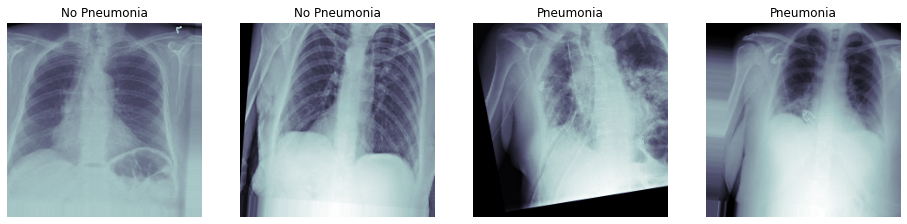

In [14]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

#train_gen=make_train_gen(train_data,my_img)
#t_x, t_y = next(train_gen)
#fig, m_axs = plt.subplots(1, 4, figsize = (16, 16))
#for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#    if c_y == 1: 
#        c_ax.set_title('Pneumonia')
#    else:
#        c_ax.set_title('No Pneumonia')
#    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model(VGG16):
    lay_of_interest='block5_pool'
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [12]:
def build_my_model(vgg_model):
    
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    new_model = Sequential()
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

# also make sure you set your optimizer, loss function, and metrics to monitor
# Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
    new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.


    #new_model.add(Dropout(0.5))

    #new_model.add(Dense(1024, activation='relu'))

    #new_model.add(Dropout(0.25))

    #new_model.add(Dense(512, activation='relu'))

    #new_model.add(Dropout(0.25))

#    new_model.add(Dense(256, activation='relu'))

#    new_model.add(Dropout(0.5))

   # new_model.add(Dense(128, activation='relu'))
    
   # new_model.add(Dropout(0.5))
    
    #new_model.add(Dense(64, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
    new_model.add(Dense(1, activation='sigmoid'))
    # Todo 10-4 to 1 lr heres how per epoch_size change after each epoch size. 
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [13]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance
# if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs 
#  without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class_bs16valadm4')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min',
                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=20)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=20)
callbacks_list = [checkpoint, early]




In [14]:
#Icycle Scheduler



### PREP training

In [15]:
## prep your model
train_gen=make_train_gen(train_data,my_img)
vgg_model=load_pretrained_model(VGG16)
my_model=build_my_model(vgg_model)
my_model.summary()


Found 2290 validated image filenames belonging to 2 classes.
553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    

### Train

In [ ]:
# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = val_gen, #(valX, valY), 
                           epochs = 30,
                           callbacks = callbacks_list)



Epoch 1/30
143/144 [============================>.] - ETA: 0s - loss: 2.5709 - binary_accuracy: 0.5598

In [20]:
!nvidia-smi

Mon Mar 29 18:50:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    62W / 149W |  11045MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
history.history.

In [18]:
history.params

{'epochs': 30,
 'steps': 144,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']}

In [19]:
history.history.items()

dict_items([('val_loss', [3.2222957611083984, 1.5891752243041992, 1.1652239561080933, 1.0932652950286865, 0.6499714851379395, 1.0624103546142578, 1.0675687789916992, 0.9837631583213806, 0.7900288105010986, 0.6916154026985168, 1.2079524993896484, 0.906141459941864, 1.2099040746688843, 0.2669149935245514, 0.8114895224571228, 1.5441845655441284]), ('val_binary_accuracy', [0.45944055914878845, 0.5160838961601257, 0.6174825429916382, 0.5909090638160706, 0.47622376680374146, 0.5804196000099182, 0.6902098059654236, 0.5825175046920776, 0.4769230782985687, 0.5384615659713745, 0.5881118774414062, 0.5195804238319397, 0.4811188876628876, 0.6342657208442688, 0.544755220413208, 0.5230769515037537]), ('loss', [2.4294017757390782, 1.5117200209063735, 1.061784553163437, 0.8263056945592555, 0.7294153643487322, 0.6607084254510538, 0.6230035981952363, 0.5710239656106874, 0.5354700380537708, 0.5288152602171794, 0.5137715061418875, 0.4752532766375479, 0.45699015277962496, 0.4637578341508016, 0.4218991581529

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect. b_s=32
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

print(len(pred_Y))
len(valX)

16/16 [==============================] - 0s 15ms/step
16


16

### Analysis 

In [21]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve ,average_precision_score,accuracy_score,f1_score
from scipy import interp
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def F1_score(precision, recall):
    return (2 * (precision * recall) / (precision + recall))

#def plot_auc(t_y, p_y):
    




    
def plot_roc_curve(ground_truth, probability):
    ## YOUR CODE HERE
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(ground_truth,probability)
    c_ax.plot([0,1],[0,1]) #line
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.4f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
## what other performance statistics do you want to include here besides AUC? 


def prec(y_test,y_score):
    
    # Todo
    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.4f}'.format(average_precision))
    print(" AUC SCORE IS : {0:0.4f}" , roc_auc_score(y_test, y_score))


    


# Todo
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(ground_truth, probability):
    ## YOUR CODE HERE
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(ground_truth, probability)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(ground_truth, probability)))
    c_ax.legend()
    c_ax.set_xlabel('Recall Rate')
    c_ax.set_ylabel('Precision Rate')
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper right")
    # Todo
    return

16

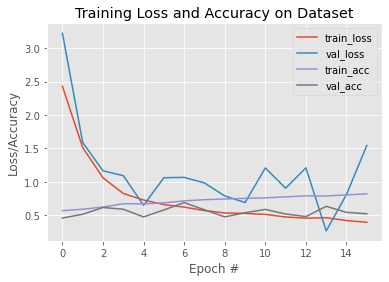

In [23]:
## plot figures

plot_history(history)

ground_truth=valY
probability=pred_Y

len(pred_Y)



In [25]:
fn = open("predY_16","w")
fn.write(str(pred_Y))
fn.close()

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

MAX of f1_scores 0.6666666666666666  max f1_scores.index IS  3 at Threshold 0.99999833
Recall at max f1 : 0.5
Pecision at max f1 : 0.5
#----------------------------- Confusion with Threshold set to 0.99999833 ----------------
confusion_matrix is 
 [[14  0]
 [ 1  1]]
Average precision-recall score: 0.7000


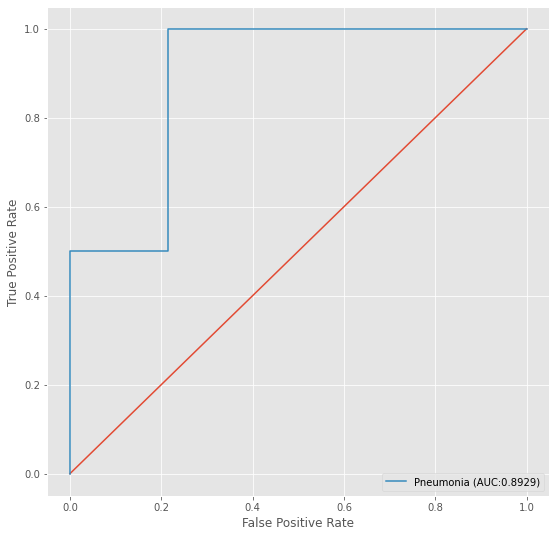

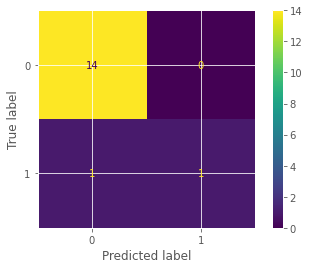

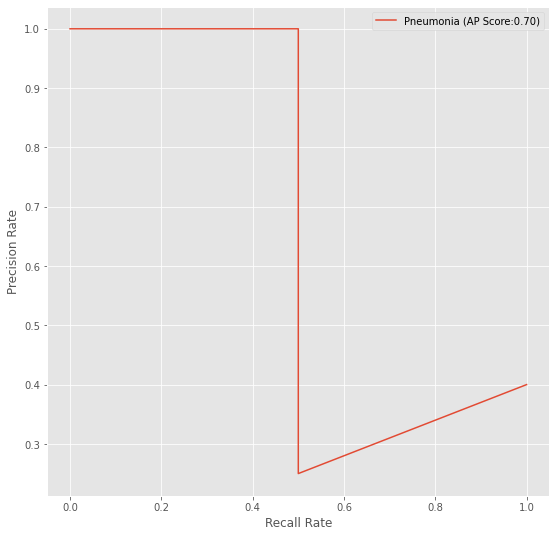

In [27]:
precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)
    

#------------------------------------------ Threshold determination ---------------------------    
# Now which threshold for f1 score do we take max or average. max(f1_score) => idx => threshold(idx)
print('MAX of f1_scores',max(f1_scores),' max f1_scores.index IS ',f1_scores.index(max(f1_scores)),'at Threshold',thresholds[f1_scores.index(max(f1_scores))])

Threshold=thresholds[f1_scores.index(max(f1_scores))]

print('Recall at max f1 :', recall[f1_scores.index(max(f1_scores))])
print('Pecision at max f1 :' ,precision[f1_scores.index(max(f1_scores))])
                                                                                                                         
                                                                                                                         
#-----------------------------  ROC ---------------------
plot_roc_curve(ground_truth, probability)
# Todo
print('#----------------------------- Confusion with Threshold set to', Threshold,'----------------')
                                                                                                                         
# Confusion Matrix we need a threshold a is dummy for display_labels parameter, it is a 1 by 2 vestor [0,1]
a=np.ndarray(shape=(1,2), dtype=float, order='F')
a=[0,1]
cm=confusion_matrix(ground_truth,binarize(probability,Threshold))
print('confusion_matrix is \n',cm)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=a).plot()



average_precision = average_precision_score(valY, pred_Y)

print('Average precision-recall score: {0:0.4f}'.format(average_precision))

#-------------------------- Plot_Precision recall Curve ----------------------
#
plot_precision_recall_curve(ground_truth,probability)                                                                                                                         
#

                

#So if I use f1.max as thresh I get an evenly distributed FP,FN

In [28]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your 
# metrics into consideration.
##
ground_truth, probability = valY,pred_Y



precision, recall, thresholds = precision_recall_curve(ground_truth, probability)

#try recall 
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print("INDEX: ",idx)
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
#THRESHOLD=thresholds[idx]
print('F1 Score is: ' + str(F1_score(precision[idx],recall[idx])))



INDEX:  0
Precision is: 0.4
Recall is: 1.0
Threshold is: 0.99995637
F1 Score is: 0.5714285714285715


max threshold 0.5
confusion_matrix is 
 [[6 8]
 [0 2]]


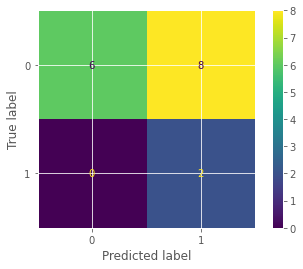

In [29]:
#try threshold  for balance first.
threshold=.5
print("max threshold",threshold)
# Confusion Matrix we need a threshold a is dummy for display_labels parameter, it is a 1 by 2 vestor [0,1]
a=np.ndarray(shape=(1,2), dtype=float, order='F')
a=[0,1]
cm=confusion_matrix(ground_truth,binarize(probability,threshold))
print('confusion_matrix is \n',cm)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=a).plot()

### A conclusion : By using a Threshold of max(F1)  will it give us a smaller FP nd FN which is ideal for screening.

Text(0, 0.5, 'F1')

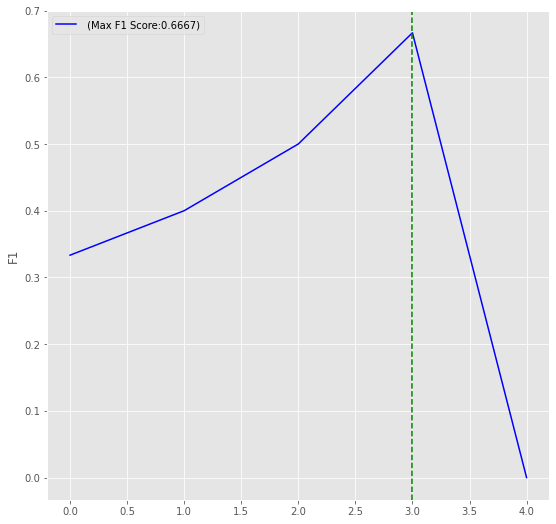

In [35]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
#c_ax=plt.axes(projection='3d')
precision, recall, thresholds = precision_recall_curve(ground_truth, probability)
c_ax.plot(f1_scores,label = '%s (Max F1 Score:%0.4f)'  % ('' ,max(f1_scores)),c="b")
plt.axvline(x=f1_scores.index(max(f1_scores)),ls="--",c='g')
#c_ax.plot(F1_score(precision,recall), label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(ground_truth, probability)),c="b")
c_ax.legend()
#c_ax.set_xlabel()
c_ax.set_ylabel('F1')

In [36]:
# Look at the threshold where precision is 0.5
precision_value = 0.50
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(F1_score(precision[idx],recall[idx])))
idx

Precision is: 0.5
Recall is: 0.5
Threshold is: 0.99999833
F1 Score is: 0.5


3

Text(0, 0.5, 'F1')

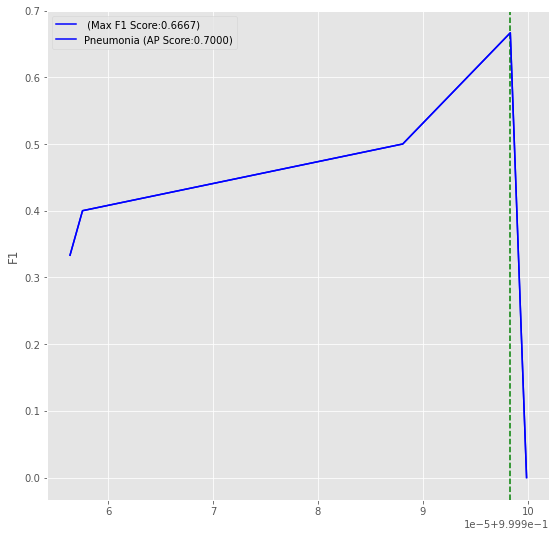

In [37]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

precision, recall, thresholds = precision_recall_curve(ground_truth, probability)

c_ax.plot(thresholds,f1_scores,label = '%s (Max F1 Score:%0.4f)'  % ('' ,max(f1_scores)),c="b")
Threshold=thresholds[f1_scores.index(max(f1_scores))]
plt.axvline(x=Threshold,ls="--",c='g')
c_ax.plot(thresholds,f1_scores, label = '%s (AP Score:%0.4f)'  % ('Pneumonia', average_precision_score(ground_truth, probability)),c="b")
c_ax.legend()
#c_ax.set_xlabel()
c_ax.set_ylabel('F1')

In [38]:
recall_value = 0.5
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(F1_score(precision[idx],recall[idx])))
idx

Precision is: 0.25
Recall is: 0.5
Threshold is: 0.99995756
F1 Score is: 0.3333333333333333


1

In [39]:
# Analysis based on recall and Precision defined

ground_truth=valY
probability=pred_Y

probs=(np.resize(pred_Y,-1))
probs=pd.Series(probs)
t1=(probs> .96)
t2=(probs>.24)
np.shape(np.resize(pred_Y,-1))


(15,)

In [40]:
t1 = t1.replace(True,1).replace(False,0)
t2 = t2.replace(True,1).replace(False,0)

In [41]:
compare_t1 = (t1 == ground_truth[:-1])
compare_t2 = (t2 == ground_truth[:-1])

In [42]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(t1)))

Accuracy at threshold 1: 0.6


In [43]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(t2)))

Accuracy at threshold 2: 0.4666666666666667


In [44]:
Threshold

0.99999833

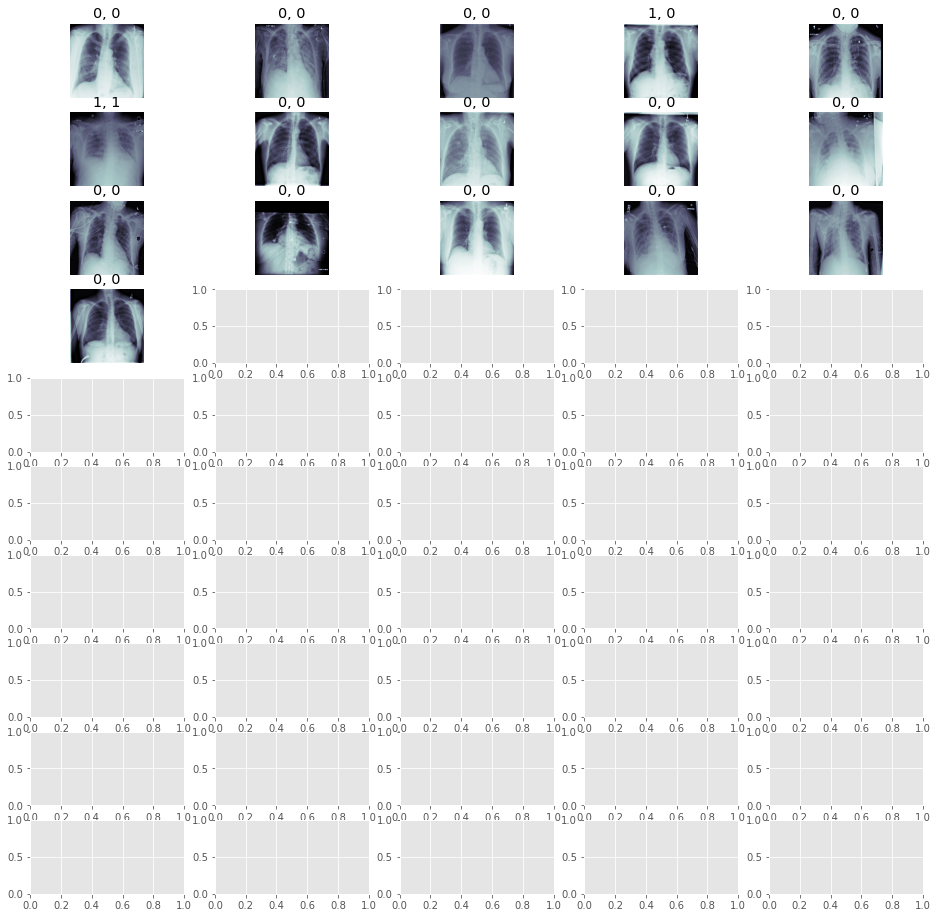

In [45]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
YOUR_THRESHOLD=Threshold
fig, m_axs = plt.subplots(10, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:51], valY[0:51], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

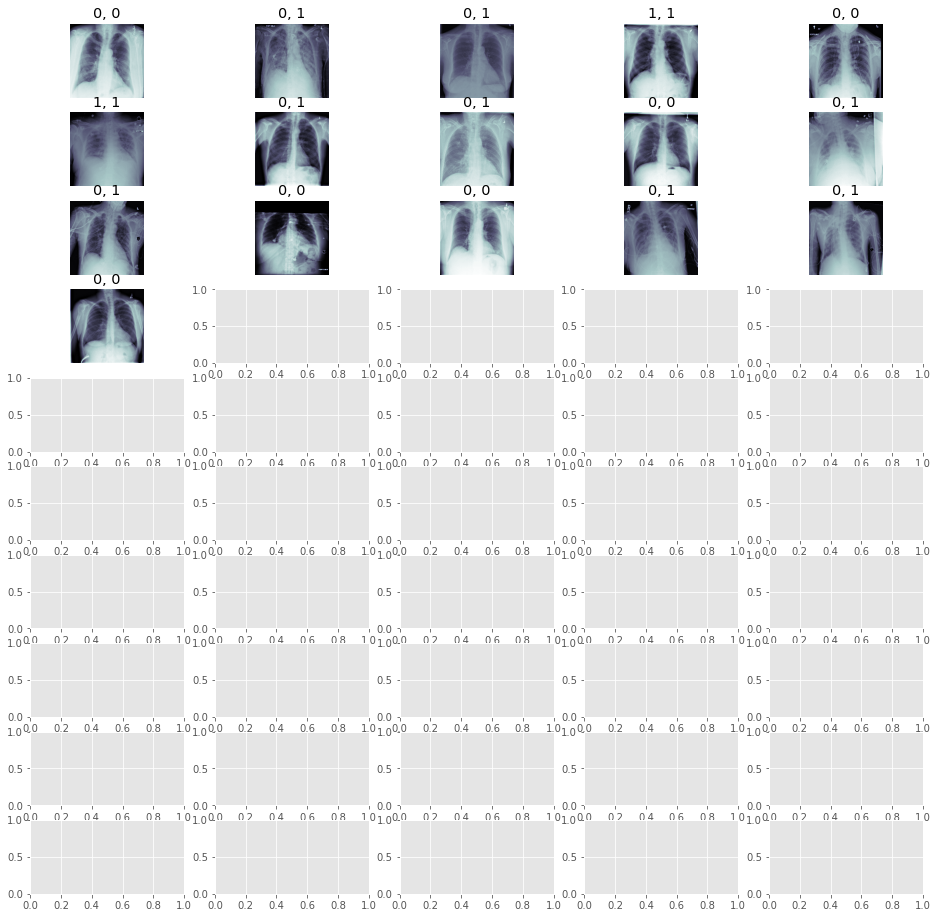

In [46]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
YOUR_THRESHOLD=.51
fig, m_axs = plt.subplots(10, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:51], valY[0:51], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [47]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model_16.json", "w") as json_file:
    json_file.write(model_json)